## Import Packages

In [1]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset

from torch.nn import CrossEntropyLoss, MSELoss

from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, BertSelfAttention, FP_BertSelfAttention, BertAttention, FP_BertAttention
from utils_glue import *

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

mse_func = MSELoss()

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


11/10 01:01:09 PM Note: detected 78 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
11/10 01:01:09 PM Note: NumExpr detected 78 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

## Dataset & Model Setting

In [90]:
task_name = "rte"
bert_size = "large"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12


# Prepare Dataset

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=True)

# Load Dataset
data_dir = os.path.join("data",task_name)

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = RandomSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

# Get input batch sample
batch = next(iter(eval_dataloader))
input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
seq_length = seq_lengths[0]

11/10 01:35:21 PM Writing example 0 of 277
11/10 01:35:21 PM *** Example ***
11/10 01:35:21 PM guid: dev-0
11/10 01:35:21 PM tokens: [CLS] dana reeve , the widow of the actor christopher reeve , has died of lung cancer at age 44 , according to the christopher reeve foundation . [SEP] christopher reeve had an accident . [SEP]
11/10 01:35:21 PM input_ids: 101 11271 20726 1010 1996 7794 1997 1996 3364 5696 20726 1010 2038 2351 1997 11192 4456 2012 2287 4008 1010 2429 2000 1996 5696 20726 3192 1012 102 5696 20726 2018 2019 4926 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
11/10 01:35:21 PM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Study Input sequence

In [92]:
# Slicing input ids & tokenize for logging
input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)

sample_sentence_a = str()
sample_sentence_b = str()
index = 0

# Studying inputs 
for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

punc_index_1 = torch.where(input_ids[0] == 1010)[0] # comma
punc_index_2 = torch.where(input_ids[0] == 1012)[0] # period
punc_index = torch.cat([punc_index_1, punc_index_2])

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"==> input_ids: \n{input_ids_sliced}")
print(f"==> tokens: \n{tokens}")

print()

print("==> Input Sequence Separation")
print(f"Sentence-A : {sample_sentence_a}")
print(f"Sentence-B : {sample_sentence_b}")

print()

print("==> Punctuation Token Index")
print(f"[SEP] index : {sep_index}")
print(f"comma index : {punc_index_1}")
print(f"period insex : {punc_index_2}")

for i, token in enumerate(tokens):
    tokens[i] = token # + "_" + str(i)


==> input_ids: 
tensor([[  101,  1996,  5850,  2008,  4030,  2091,  2030,  9190, 21901,  1005,
          1055,  4295,  2147,  2190,  1996,  3041,  2017, 21497,  2068,  1012,
           102, 21901,  1005,  1055,  4295,  2003,  5845,  2478,  5850,  1012,
           102]])
==> tokens: 
['[CLS]', 'the', 'drugs', 'that', 'slow', 'down', 'or', 'halt', 'alzheimer', "'", 's', 'disease', 'work', 'best', 'the', 'earlier', 'you', 'administer', 'them', '.', '[SEP]', 'alzheimer', "'", 's', 'disease', 'is', 'treated', 'using', 'drugs', '.', '[SEP]']

==> Input Sequence Separation
Sentence-A : the drugs that slow down or halt alzheimer ' s disease work best the earlier you administer them . 
Sentence-B : alzheimer ' s disease is treated using drugs . 

==> Punctuation Token Index
[SEP] index : tensor([20, 30])
comma index : tensor([], dtype=torch.int64)
period insex : tensor([19, 29])


# Build Model

In [93]:
# Build Model
teacher_model_dir = "models/BERT_large/sst-2"
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
print("Teacher Model - FP Fine-Tuned Model")

student_model_M_dir = "output/BERT_large/sst-2/exploration/sst-2_large_map_large_M_42"
student_config = BertConfig.from_pretrained(student_model_M_dir)             
student_model_M = QuantBertForSequenceClassification.from_pretrained(student_model_M_dir, config = student_config, num_labels=num_labels)
print("Student Model - Attention Map KD-QAT")

student_model_O_dir = "output/BERT_large/sst-2/exploration/sst-2_large_output_large_O_42"
student_config = BertConfig.from_pretrained(student_model_O_dir)             
student_model_O = QuantBertForSequenceClassification.from_pretrained(student_model_O_dir, config = student_config, num_labels=num_labels)
print("Student Model - Attention Output KD-QAT")


Teacher Model - FP Fine-Tuned Model
Student Model - Attention Map KD-QAT
Student Model - Attention Output KD-QAT


# Attention Output Comp Min-Max (Figure. 5)


In [58]:
# Model Inference
teacher_outputs = teacher_model(input_ids_sliced)
student_outputs_M  = student_model_M(input_ids_sliced)
student_outputs_O  = student_model_O(input_ids_sliced)

teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_attn_blocks = teacher_outputs
student_logits, student_atts, student_reps, student_probs, student_attn_blocks_M = student_outputs_M
student_logits, student_atts, student_reps, student_probs, student_attn_blocks_O = student_outputs_O

In [59]:
# Dictionary Setting
mag_dict = dict()
for l in range(layer_num):        
    mag_dict[f"tc_min_{l}"] = []; mag_dict[f"tc_max_{l}"] = []
    mag_dict[f"QAT-M_min_{l}"] = []; mag_dict[f"QAT-M_max_{l}"] = []
    mag_dict[f"QAT-O_min_{l}"] = []; mag_dict[f"QAT-O_max_{l}"] = []

# Extract Attention Output per input Hidden dimension's min-max
for l in range(layer_num):
    
    # You can either observe each attention related signal choosing one of following outputs
    # -> (attention-context, attention-output, attention-self-attention-output)
    tc_attn_context, tc_attn_output, tc_sa_output = teacher_attn_blocks[l]
    st_attn_context, st_attn_output_M, st_sa_output = student_attn_blocks_M[l]        
    st_attn_context, st_attn_output_O, st_sa_output = student_attn_blocks_O[l]        
    
    for token in range(len(tokens)):
        mag_dict[f"tc_min_{l}"].append(tc_attn_output[0,token,:].min().item())
        mag_dict[f"tc_max_{l}"].append(tc_attn_output[0,token,:].max().item())

        mag_dict[f"QAT-M_min_{l}"].append(st_attn_output_M[0,token,:].min().item())
        mag_dict[f"QAT-M_max_{l}"].append(st_attn_output_M[0,token,:].max().item())
        
        mag_dict[f"QAT-O_min_{l}"].append(st_attn_output_O[0,token,:].min().item())
        mag_dict[f"QAT-O_max_{l}"].append(st_attn_output_O[0,token,:].max().item())
 

In [62]:
# Save
torch.save(mag_dict, f"analysis_outputs/{task_name}_{bert_size}_min-max.pth")

## Min-Max Plot (Figure. 5)

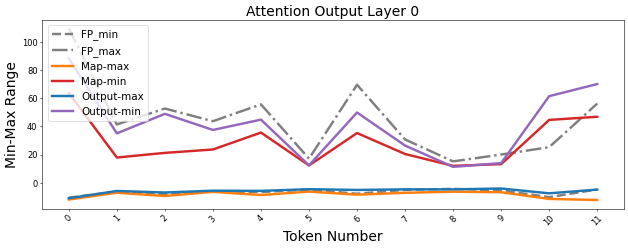

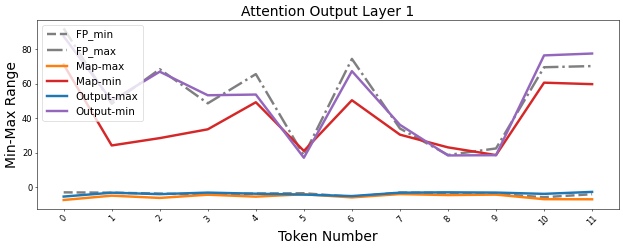

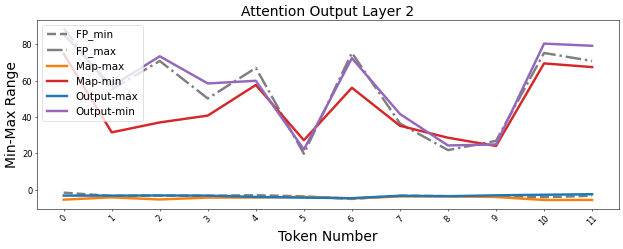

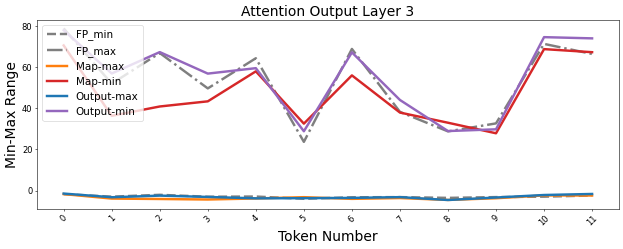

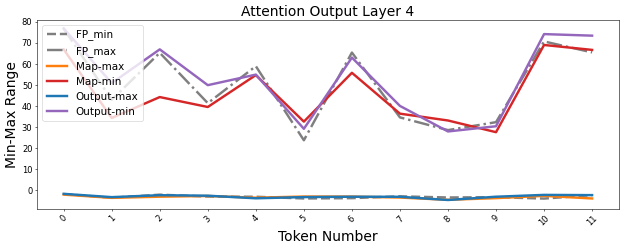

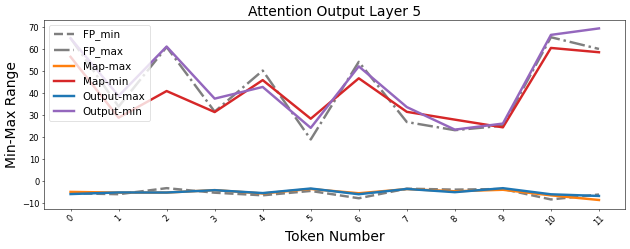

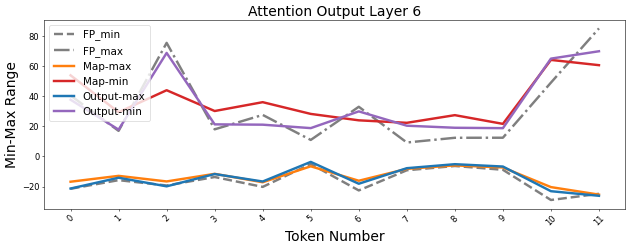

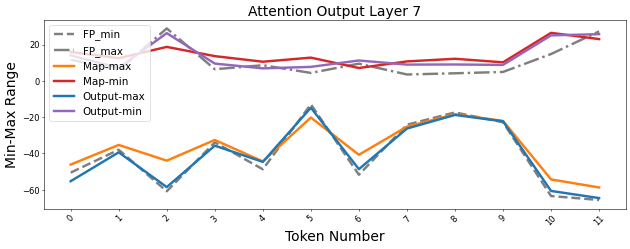

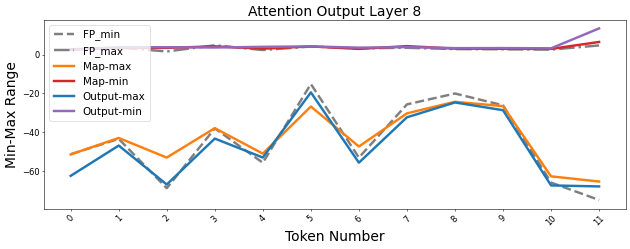

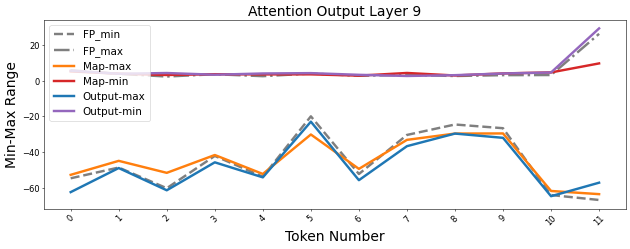

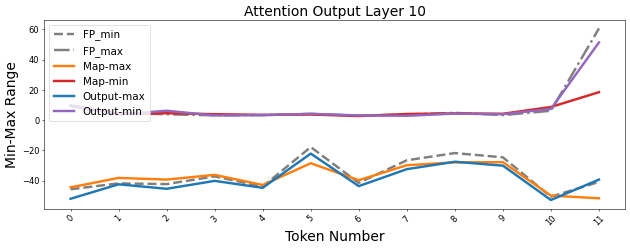

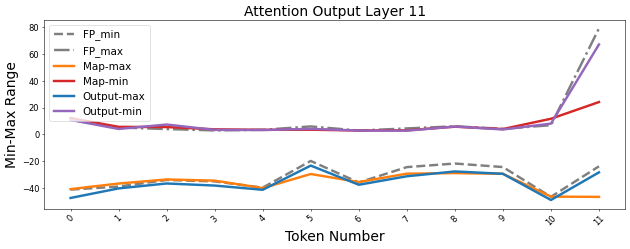

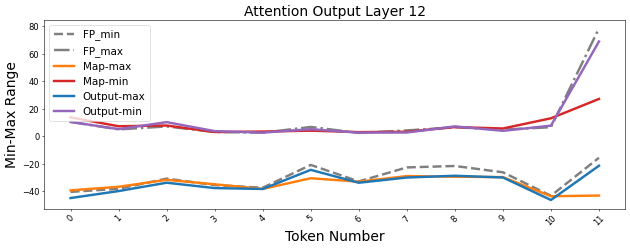

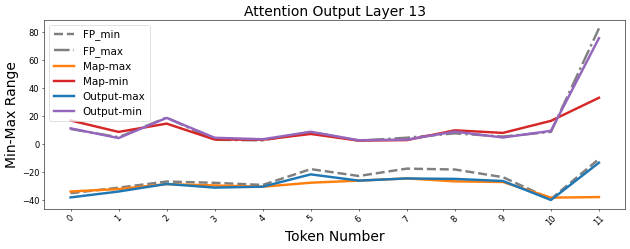

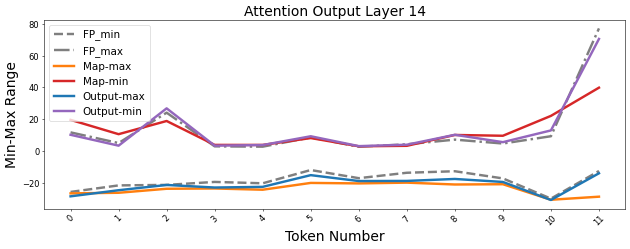

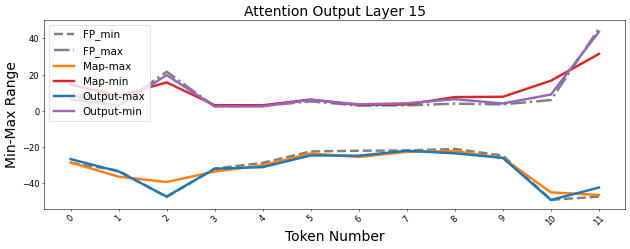

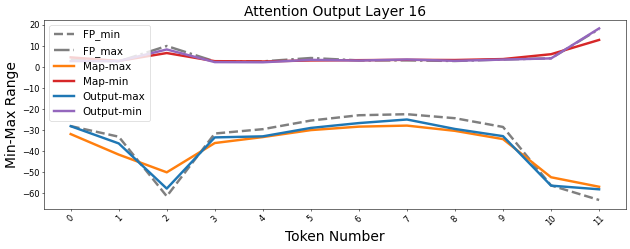

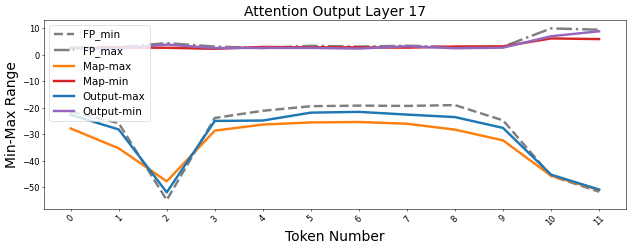

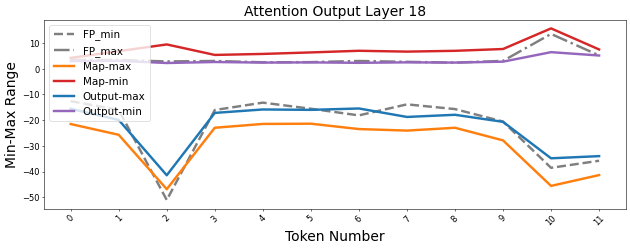

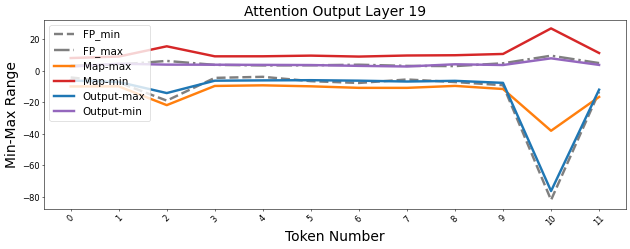

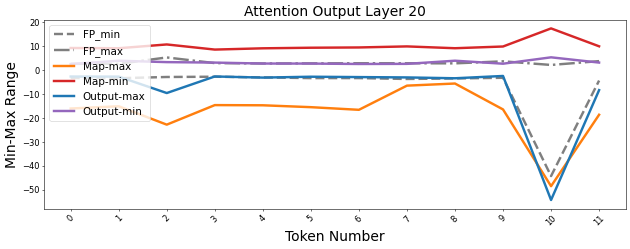

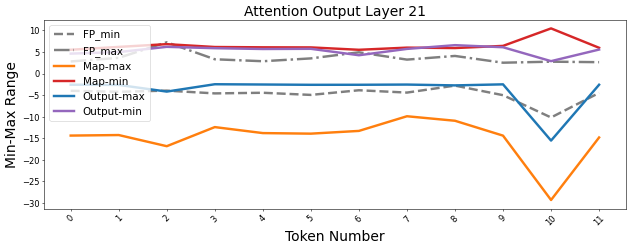

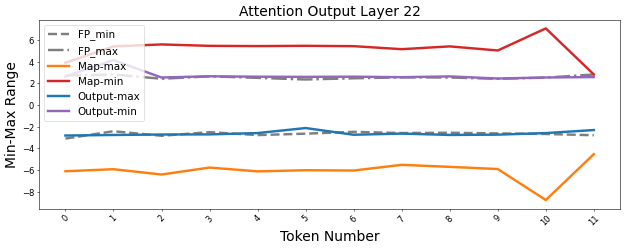

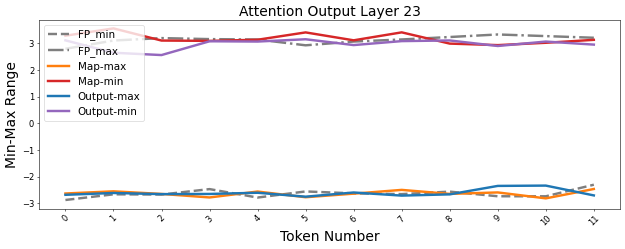

In [63]:
mag_dict = torch.load(f"analysis_outputs/{task_name}_{bert_size}_min-max.pth")
lw = 3.5
for l in range(layer_num):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=50)
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_min_{l}"], label="FP_min", color="tab:gray", linewidth=lw, linestyle="--")
    ax.plot(list(range(len(tokens))), mag_dict[f"tc_max_{l}"], label="FP_max", color="tab:gray", linewidth=lw, linestyle="-.")

    ax.plot(list(range(len(tokens))), mag_dict[f"QAT-M_min_{l}"], label="Map-max", color="tab:orange", linewidth=lw)
    ax.plot(list(range(len(tokens))), mag_dict[f"QAT-M_max_{l}"], label="Map-min", color="tab:red", linewidth=lw)
    
    ax.plot(list(range(len(tokens))), mag_dict[f"QAT-O_min_{l}"], label="Output-max", color="tab:blue", linewidth=lw)
    ax.plot(list(range(len(tokens))), mag_dict[f"QAT-O_max_{l}"], label="Output-min", color="tab:purple", linewidth=lw)

    ax.set_title(f"Attention Output Layer {l}", fontsize=20)
    ax.legend(loc=2, fontsize=15)
    plt.xticks(range(len(tokens)),rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xlabel("Token Number", fontsize=20)
    ax.set_ylabel("Min-Max Range", fontsize=20)
    plt.show()





# Norm Based Analysis (Figure. 6)

In [64]:
# For Attention norm analysis (https://github.com/gorokoba560/norm-analysis-of-transformer)
for name, module in student_model_M.named_modules():
    if isinstance(module, BertAttention):    
        module.output_norm = True
for name, module in student_model_O.named_modules():
    if isinstance(module, BertAttention):    
        module.output_norm = True
for name, module in teacher_model.named_modules():
    if isinstance(module, FP_BertAttention):    
        module.output_norm = True

## Per Head Attention Norm Analysis

In [65]:
# Model Inference
teacher_outputs = teacher_model(input_ids_sliced)
student_outputs_M  = student_model_M(input_ids_sliced)
student_outputs_O  = student_model_O(input_ids_sliced)

teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_attn_blocks = teacher_outputs
student_logits, student_atts, student_reps, student_probs_M, student_attn_blocks_M = student_outputs_M
student_logits, student_atts, student_reps, student_probs_O, student_attn_blocks_O = student_outputs_O

norm_func = torch.linalg.norm

# Lists to save attention norm
table_tc_prob = [[0] * head_num for i in range(layer_num)]
table_st_prob_M = [[0] * head_num for i in range(layer_num)]
table_st_prob_O = [[0] * head_num for i in range(layer_num)]
table_diff_prob_M = [[0] * head_num for i in range(layer_num)]
table_diff_prob_O = [[0] * head_num for i in range(layer_num)]

table_tc_fx = [[0] * head_num for i in range(layer_num)]
table_st_fx_M = [[0] * head_num for i in range(layer_num)]
table_st_fx_O = [[0] * head_num for i in range(layer_num)]
table_diff_fx_M = [[0] * head_num for i in range(layer_num)]
table_diff_fx_O = [[0] * head_num for i in range(layer_num)]

table_tc_afx = [[0] * head_num for i in range(layer_num)]
table_st_afx_M = [[0] * head_num for i in range(layer_num)]
table_st_afx_O = [[0] * head_num for i in range(layer_num)]
table_diff_afx_M = [[0] * head_num for i in range(layer_num)]
table_diff_afx_O = [[0] * head_num for i in range(layer_num)]

token_index = sep_index[0] # You can choose any token you want to analyze (Default : [SEP] Token)

# Compare Attention norm (SA-GEN, SA-PROP)
for l in range(layer_num):

    tc_prob = teacher_probs[l]
    st_prob_M = student_probs_M[l]
    st_prob_O = student_probs_O[l]

    tc_attn_context, tc_attn_output, tc_norms_outputs = teacher_attn_blocks[l]
    st_attn_context, st_attn_output_M, st_norms_outputs_M = student_attn_blocks_M[l]        
    st_attn_context, st_attn_output_O, st_norms_outputs_O = student_attn_blocks_O[l]        

    tc_transformed_norm, tc_weighted_norm, tc_summed_weighted_norm, _ = tc_norms_outputs
    st_transformed_norm_M, st_weighted_norm_M, st_summed_weighted_norm_M, _ = st_norms_outputs_M
    st_transformed_norm_O, st_weighted_norm_O, st_summed_weighted_norm_O, _ = st_norms_outputs_O
    
    for h in range(head_num):
        table_tc_prob[l][h] = tc_prob[:,h,:,token_index].mean().item()
        table_st_prob_M[l][h] = st_prob_M[:,h,:,token_index].mean().item()
        table_st_prob_O[l][h] = st_prob_O[:,h,:,token_index].mean().item()
        table_diff_prob_M[l][h] = (tc_prob[:,h,token_index].mean() - st_prob_M[:,h,token_index].mean()).abs().item()
        table_diff_prob_O[l][h] = (tc_prob[:,h,token_index].mean() - st_prob_O[:,h,token_index].mean()).abs().item()
        
        table_tc_fx[l][h] = norm_func(tc_transformed_norm[:,h,token_index], dim=-1).item()
        table_st_fx_M[l][h] = norm_func(st_transformed_norm_M[:,h,token_index], dim=-1).item()
        table_st_fx_O[l][h] = norm_func(st_transformed_norm_O[:,h,token_index], dim=-1).item()
        table_diff_fx_M[l][h] = (norm_func(tc_transformed_norm[:,h,token_index], dim=-1) - norm_func(st_transformed_norm_M[:,h,token_index], dim=-1)).abs().item()
        table_diff_fx_O[l][h] = (norm_func(tc_transformed_norm[:,h,token_index], dim=-1) - norm_func(st_transformed_norm_O[:,h,token_index], dim=-1)).abs().item()
        
        table_tc_afx[l][h] = norm_func(tc_weighted_norm[:,h,token_index], dim=-1).item()
        table_st_afx_M[l][h] = norm_func(st_weighted_norm_M[:,h,token_index], dim=-1).item()
        table_st_afx_O[l][h] = norm_func(st_weighted_norm_O[:,h,token_index], dim=-1).item()
        table_diff_afx_M[l][h] = (norm_func(tc_weighted_norm[:,h,token_index,:], dim=-1) - norm_func(st_weighted_norm_M[:,h,token_index,:], dim=-1)).abs().item()
        table_diff_afx_O[l][h] = (norm_func(tc_weighted_norm[:,h,token_index,:], dim=-1) - norm_func(st_weighted_norm_O[:,h,token_index,:], dim=-1)).abs().item()
        
        

        
    

## Per Head Attenion Norm Analysis Visualization (Heatmap)

Text(0.5, 1.0, 'ST-Output DIFF || af(x) ||')

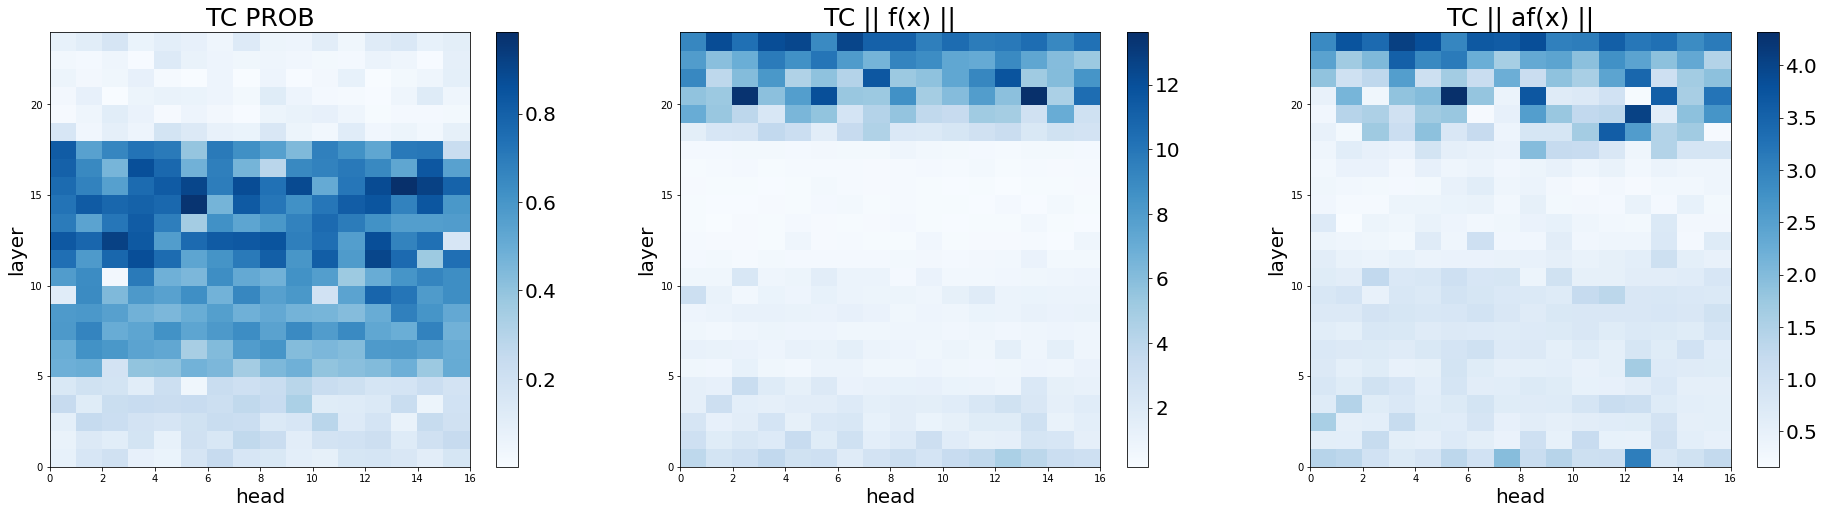

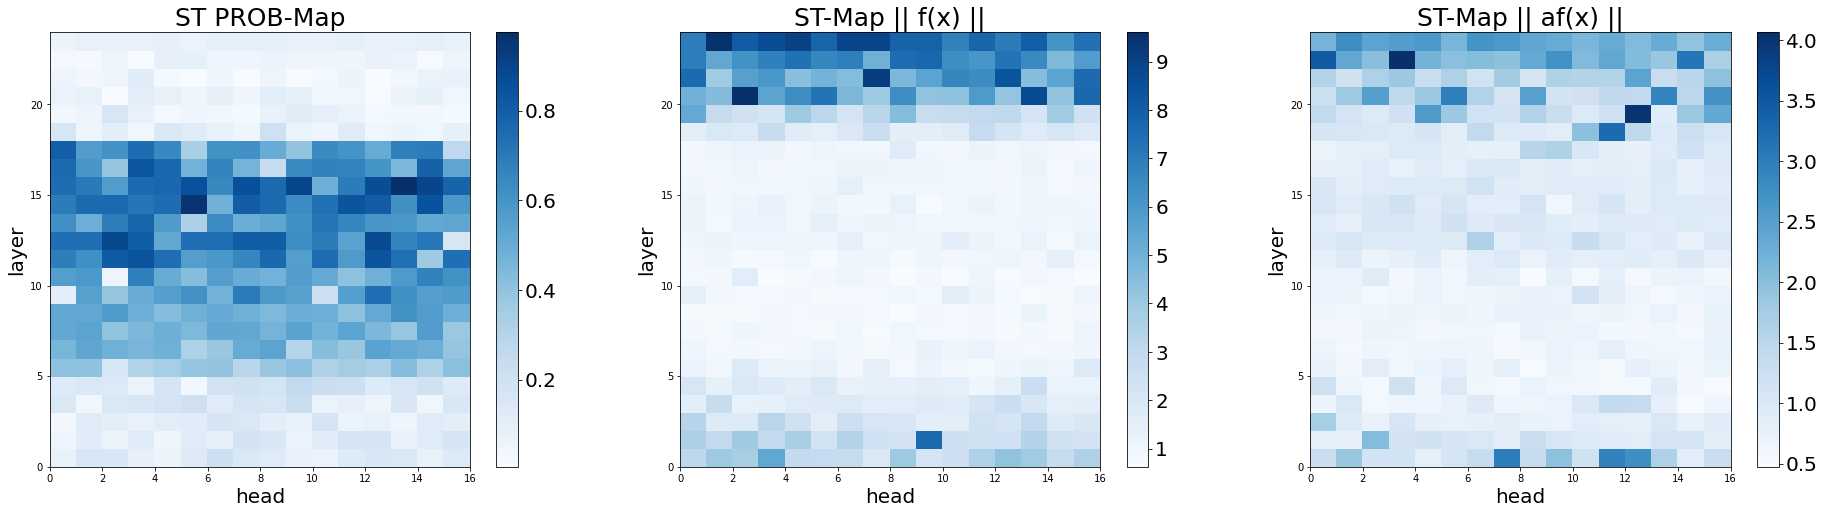

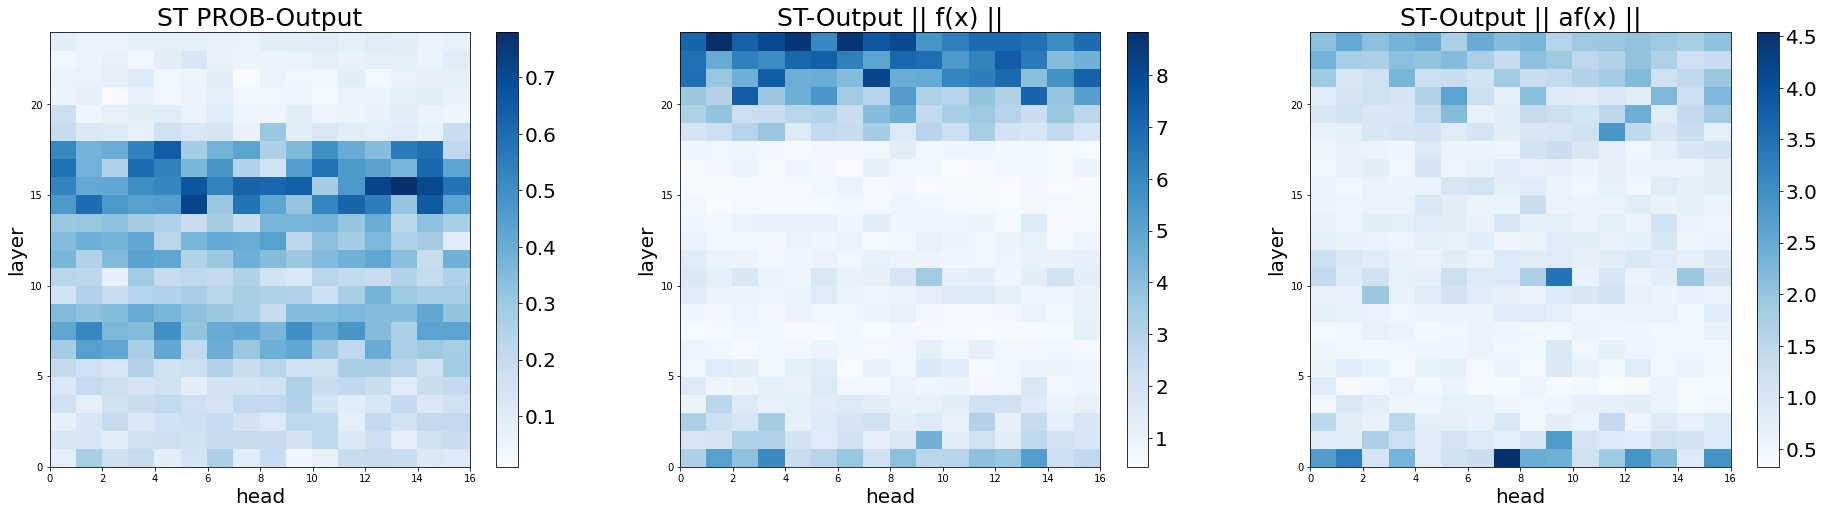

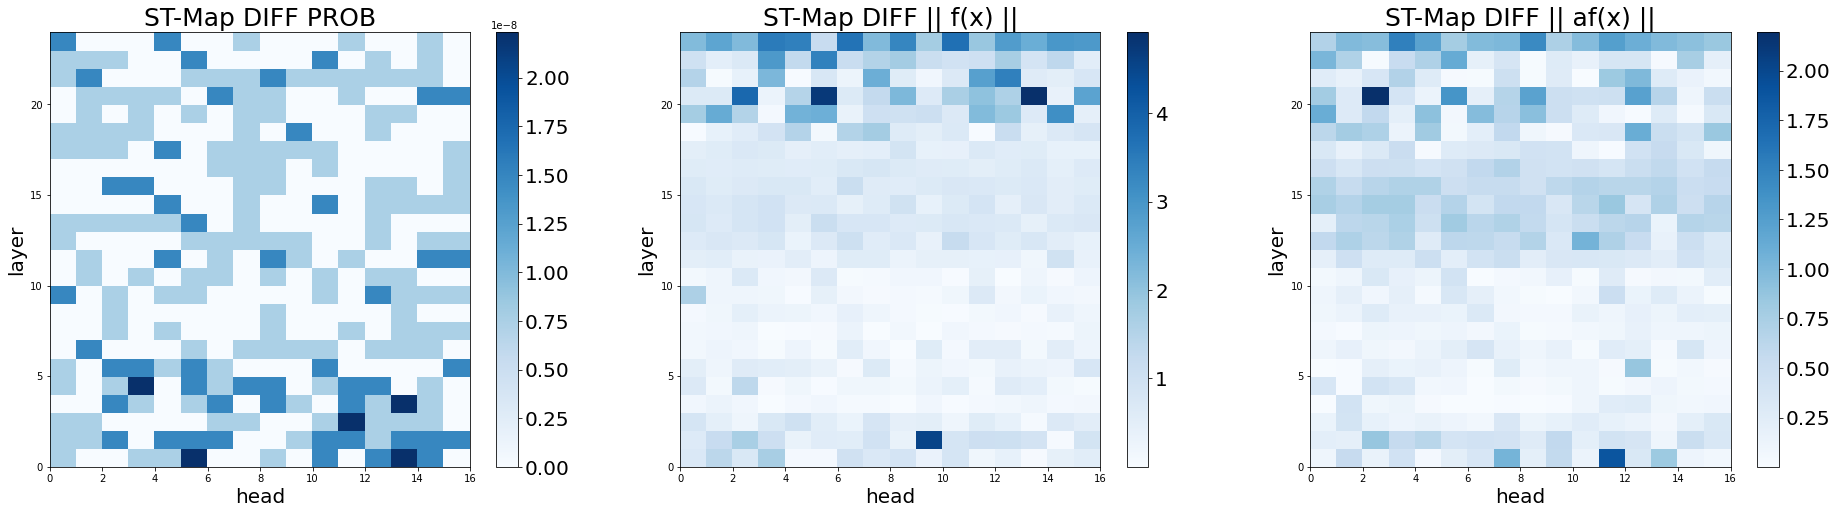

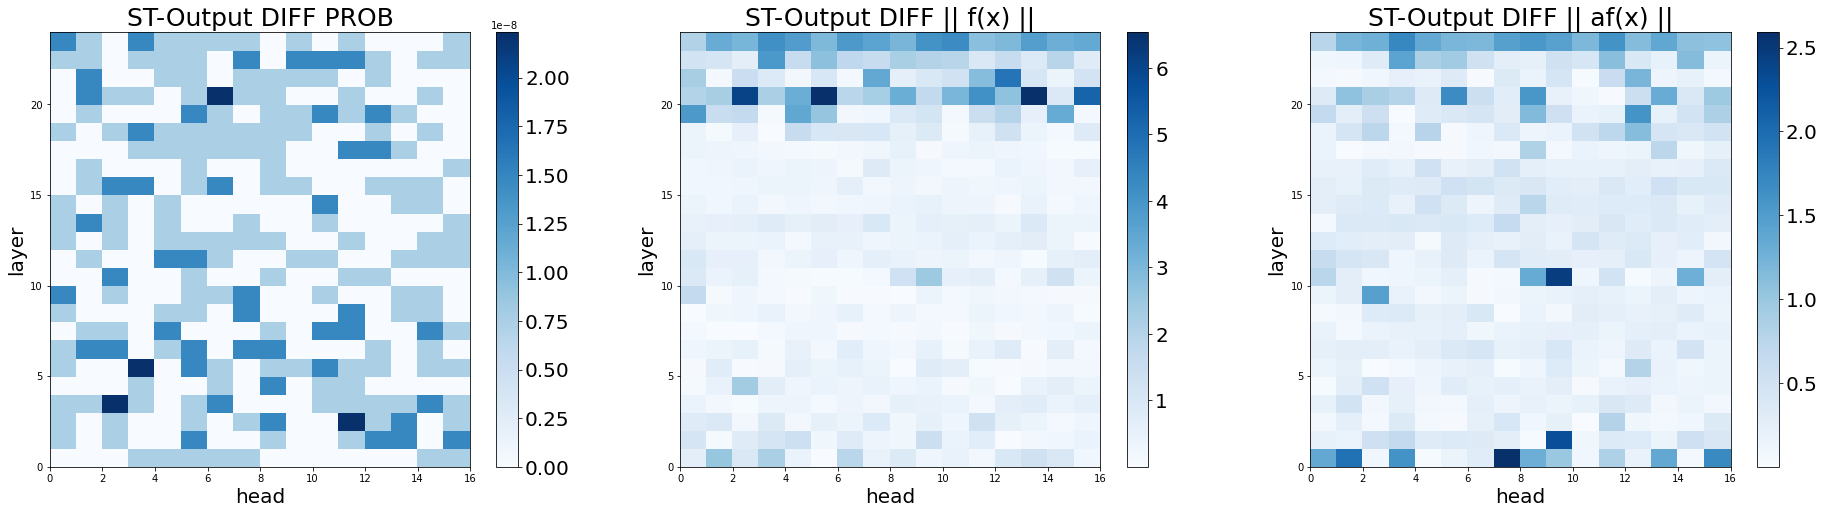

In [66]:
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

# Teacher Per Head Attention Norm Visualization
ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_tc_prob, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("TC PROB", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_tc_fx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("TC || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_tc_afx, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("TC || af(x) ||", fontsize=25)
        
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

# Student Attention-Map Per Head Attention Norm Visualization

ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_st_prob_M, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("ST PROB-Map", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_st_fx_M, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("ST-Map || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_st_afx_M, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("ST-Map || af(x) ||", fontsize=25)

# Student Attention-Output Per Head Attention Norm Visualization

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_st_prob_O, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("ST PROB-Output", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_st_fx_O, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("ST-Output || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_st_afx_O, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("ST-Output || af(x) ||", fontsize=25)


# Student-Teacher Per Head Attention Norm Difference Visualizaiton

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_diff_prob_M, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("ST-Map DIFF PROB", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_diff_fx_M, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("ST-Map DIFF || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_diff_afx_M, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("ST-Map DIFF || af(x) ||", fontsize=25)

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))

ax1.set_xlabel("head", fontsize=20); ax1.set_ylabel("layer", fontsize=20)
heatmap=ax1.pcolor(table_diff_prob_O, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax1)
cb.ax.tick_params(labelsize=20)
ax1.set_title("ST-Output DIFF PROB", fontsize=25)

ax2.set_xlabel("head", fontsize=20); ax2.set_ylabel("layer", fontsize=20)
heatmap=ax2.pcolor(table_diff_fx_O, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax2)
cb.ax.tick_params(labelsize=20)
ax2.set_title("ST-Output DIFF || f(x) ||", fontsize=25)

ax3.set_xlabel("head", fontsize=20); ax3.set_ylabel("layer", fontsize=20)
heatmap=ax3.pcolor(table_diff_afx_O, cmap=plt.cm.Blues)
cb = fig.colorbar(heatmap, ax=ax3)
cb.ax.tick_params(labelsize=20)
ax3.set_title("ST-Output DIFF || af(x) ||", fontsize=25)

        

## Per Layer Attenion Norm Analysis Visualization (Figure. 6)

In [103]:
# For Attention norm analysis (https://github.com/gorokoba560/norm-analysis-of-transformer)
for name, module in student_model_M.named_modules():
    if isinstance(module, BertAttention):    
        module.output_norm = True
for name, module in student_model_O.named_modules():
    if isinstance(module, BertAttention):    
        module.output_norm = True
for name, module in teacher_model.named_modules():
    if isinstance(module, FP_BertAttention):    
        module.output_norm = True

In [110]:
norm_func = torch.linalg.norm

# Dict to save token attention norm
diff_dict = dict()

# AverageMeter to save attention norm
for norm in ["prob", "tr", "wt"]:
    for token in ["sep", "punc", "cls", "other", "all"]:
        diff_dict[f"output_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]
        diff_dict[f"map_{norm}_{token}_diff"] = [ AverageMeter() for i in range(layer_num)]

count = 0
for batch in tqdm(eval_dataloader):
    #     if count >= 30:
    #         break
     
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    input_ids_sliced = input_ids[:,:seq_length]
    
    if 102 not in input_ids_sliced:
        continue
    
    # Model Inference
    teacher_outputs = teacher_model(input_ids_sliced)
    student_outputs_M  = student_model_M(input_ids_sliced)
    student_outputs_O  = student_model_O(input_ids_sliced)

    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_attn_blocks = teacher_outputs
    student_logits, student_atts, student_reps, student_probs_M, student_attn_blocks_M = student_outputs_M
    student_logits, student_atts, student_reps, student_probs_O, student_attn_blocks_O = student_outputs_O
    
    # From https://github.com/gorokoba560/norm-analysis-of-transformer
    ids = input_ids_sliced.clone().detach().cpu()
    
    cls_id = 101
    sep_id = 102
    comma_id = torch.tensor(tokenizer.convert_tokens_to_ids(","))
    period_id = torch.tensor(tokenizer.convert_tokens_to_ids("."))
    
    ids[ids==cls_id] = -1
    ids[ids==sep_id] = -2
    ids[ids==comma_id] = -3
    ids[ids==period_id] = -3
    ids[ids>0] = -4
    
    for l in range(layer_num):
        
        tc_prob = teacher_probs[l]
        st_prob_M = student_probs_M[l]
        st_prob_O = student_probs_O[l]

        tc_attn_context, tc_attn_output, tc_norms_outputs = teacher_attn_blocks[l]
        st_attn_context, st_attn_output_M, st_norms_outputs_M = student_attn_blocks_M[l]        
        st_attn_context, st_attn_output_O, st_norms_outputs_O = student_attn_blocks_O[l]        

        tc_transformed_norm, tc_weighted_norm, tc_summed_weighted_norm, _ = tc_norms_outputs
        st_transformed_norm_M, st_weighted_norm_M, st_summed_weighted_norm_M, _ = st_norms_outputs_M
        st_transformed_norm_O, st_weighted_norm_O, st_summed_weighted_norm_O, _ = st_norms_outputs_O
        
        for name in ["output", "map"]:
            
            if name == "map":
                st_prob = st_prob_M
                st_transformed_norm = st_transformed_norm_M
                st_summed_weighted_norm = st_summed_weighted_norm_M
            if name == "output":
                st_prob = st_prob_O
                st_transformed_norm = st_transformed_norm_O
                st_summed_weighted_norm = st_summed_weighted_norm_O
            
            diff_dict[f"{name}_prob_cls_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-1]) - torch.mean(st_prob[0,:,:,ids[0]==-1])).abs().item())
            diff_dict[f"{name}_prob_sep_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-2]) - torch.mean(st_prob[0,:,:,ids[0]==-2])).abs().item())
            diff_dict[f"{name}_prob_other_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-4]) - torch.mean(st_prob[0,:,:,ids[0]==-4])).abs().item())
            diff_dict[f"{name}_prob_all_diff"][l].update((torch.mean(tc_prob[0,:,:,:]) - torch.mean(st_prob[0,:,:,:])).abs().item())

            diff_dict[f"{name}_tr_cls_diff"][l].update((torch.mean(tc_transformed_norm[0,:,ids[0]==-1]) -torch.mean(st_transformed_norm[0,:,ids[0]==-1])).abs().item())
            diff_dict[f"{name}_tr_sep_diff"][l].update((torch.mean(tc_transformed_norm[0,:,ids[0]==-2]) - torch.mean(st_transformed_norm[0,:,ids[0]==-2])).abs().item())
            diff_dict[f"{name}_tr_other_diff"][l].update((torch.mean(tc_transformed_norm[0,:,ids[0]==-4]) - torch.mean(st_transformed_norm[0,:,ids[0]==-4])).abs().item())
            diff_dict[f"{name}_tr_all_diff"][l].update((torch.mean(tc_transformed_norm[0,:,:]) - torch.mean(st_transformed_norm[0,:,:])).abs().item())

            diff_dict[f"{name}_wt_cls_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-1]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-1])).abs().item())
            diff_dict[f"{name}_wt_sep_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-2]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-2])).abs().item())
            diff_dict[f"{name}_wt_other_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-4]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-4])).abs().item())
            diff_dict[f"{name}_wt_all_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,:]) - torch.mean(st_summed_weighted_norm[0,:,:])).abs().item())
            
            # when input sequence has comma.
            if -3 in ids:
                diff_dict[f"{name}_prob_punc_diff"][l].update((torch.mean(tc_prob[0,:,:,ids[0]==-3]) - torch.mean(st_prob[0,:,:,ids[0]==-3])).abs().item())
                diff_dict[f"{name}_wt_punc_diff"][l].update((torch.mean(tc_summed_weighted_norm[0,:,ids[0]==-3]) - torch.mean(st_summed_weighted_norm[0,:,ids[0]==-3])).abs().item())
    count += 1

 33% 92/277 [01:49<03:40,  1.19s/it]


## Plot Figure. 6

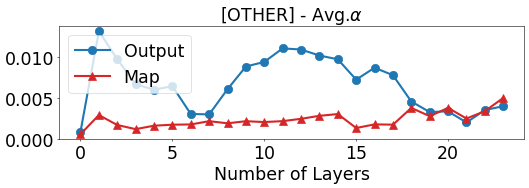

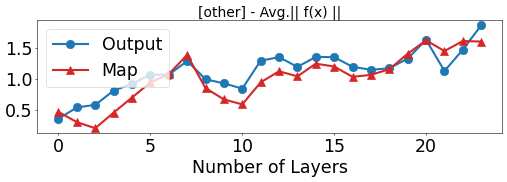

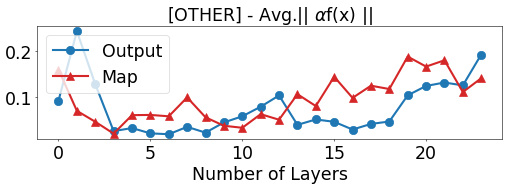

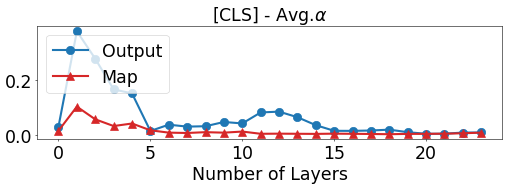

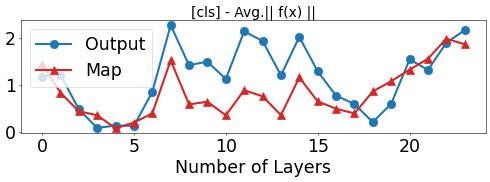

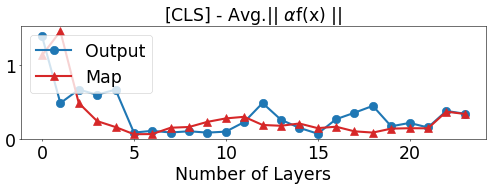

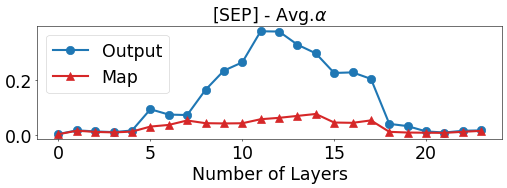

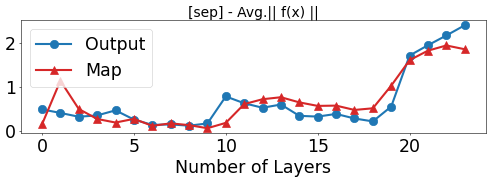

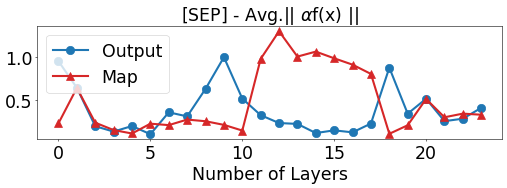

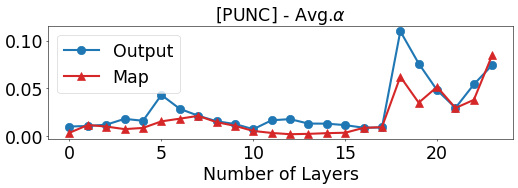

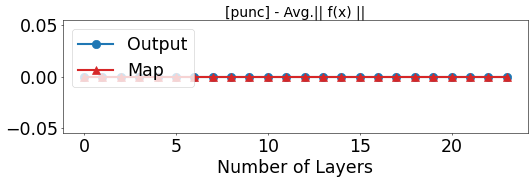

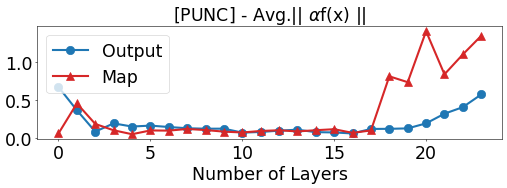

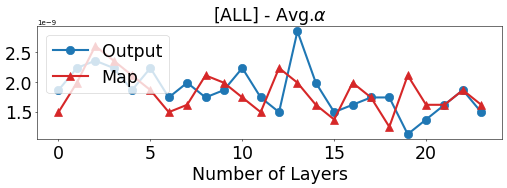

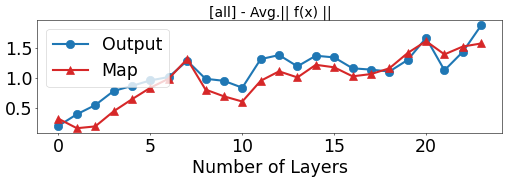

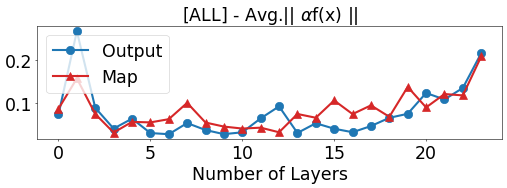

In [112]:

map_c = "orange"
out_c = "r"
graph_dict = dict()

color_1 = "tab:blue"
color_2 = "tab:red"

lw = 3
ms = 12
fs= 25
for norm in ["prob", "tr", "wt"]:
    for token in ["sep", "punc", "cls", "other", "all"]:
        graph_dict[f"output_{norm}_{token}_diff"] = []
        graph_dict[f"map_{norm}_{token}_diff"] = []
        
for l in range(layer_num):
    for norm in ["prob", "tr", "wt"]:
        for token in ["sep", "punc", "cls", "other", "all"]:
            graph_dict[f"output_{norm}_{token}_diff"].append(diff_dict[f"output_{norm}_{token}_diff"][l].avg)
            graph_dict[f"map_{norm}_{token}_diff"].append(diff_dict[f"map_{norm}_{token}_diff"][l].avg)

for name in ["other", "cls", "sep", "punc", "all"]:
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 3), dpi=50)
    fig.subplots_adjust(hspace=0.6)
    ax1.set_title(f"[{name.upper()}] - Avg.$α$", fontsize=fs)
    ax1.plot(list(range(layer_num)), graph_dict[f"output_prob_{name}_diff"], linewidth=lw, label="Output", marker='o', markersize=ms, color=color_1)
    ax1.plot(list(range(layer_num)), graph_dict[f"map_prob_{name}_diff"], linewidth=lw, label=f"Map", marker='^', markersize=ms, color=color_2)
    ax1.legend(loc=2, fontsize=fs)
    ax1.tick_params(axis='x', labelsize=fs)
    ax1.tick_params(axis='y', labelsize=fs)
    ax1.set_xlabel("Number of Layers", fontsize=fs)
    
    fig, ax2 = plt.subplots(1, 1, figsize=(12, 3), dpi=50)
    ax2.set_title(f"[{name}] - Avg.|| f(x) ||", fontsize=20)
    ax2.plot(list(range(layer_num)), graph_dict[f"output_tr_{name}_diff"], linewidth=lw, label="Output", marker='o', markersize=ms, color=color_1)
    ax2.plot(list(range(layer_num)), graph_dict[f"map_tr_{name}_diff"], linewidth=lw, label=f"Map", marker='^', markersize=ms, color=color_2)
    ax2.legend(loc=2, fontsize=fs)
    ax2.tick_params(axis='x', labelsize=fs)
    ax2.tick_params(axis='y', labelsize=fs)
    ax2.set_xlabel("Number of Layers", fontsize=fs)
    
    fig, ax3 = plt.subplots(1, 1, figsize=(12, 3), dpi=50)
    ax3.set_title(f"[{name.upper()}] - Avg.|| $α$f(x) ||", fontsize=fs)
    ax3.plot(list(range(layer_num)), graph_dict[f"output_wt_{name}_diff"], linewidth=lw, label="Output", marker='o', markersize=ms, color=color_1)
    ax3.plot(list(range(layer_num)), graph_dict[f"map_wt_{name}_diff"], linewidth=lw, label=f"Map", marker='^', markersize=ms, color=color_2)
    ax3.legend(loc=2, fontsize=fs)
    ax3.tick_params(axis='x', labelsize=fs)
    ax3.tick_params(axis='y', labelsize=fs)
    ax3.set_xlabel("Number of Layers", fontsize=fs)


In [99]:
torch.save(graph_dict, f"analysis_outputs/{task_name}_{bert_size}_norm_analysis.pth")